In [3]:
from IPython.display import display, Image, clear_output
import pandas as pd
import random 
import re 
import numpy as np
import music21 as m21
import time
import nltk 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

# 200806695 MSC Project

## An intelligent tutoring system (ITS) for music theory teaching

### Part 1 - a non intelligent tutoring system

#### Loading the questions data

 The questions are png images of notes on a stave that were generated with the music21 library. Below is a (lookup table?) which can be used to access the png image for the questions (or the xml if need be).

In [4]:
data = './q_folders/stave/labels_treble.csv'
data = pd.read_csv(data)
data.head()


,xmlfile,pngfile,label
0,treble_C4.xml,treble_C4-1.png,C
1,treble_D4.xml,treble_D4-1.png,D
2,treble_E4.xml,treble_E4-1.png,E
3,treble_F4.xml,treble_F4-1.png,F
4,treble_G4.xml,treble_G4-1.png,G


Below is an example of how data from the table can be used to generate a question and answer from the database.

In [5]:
data = './q_folders/transpose/bb/labels.csv'
# data = './q_folders/stave/labels_treble.csv'
data = pd.read_csv(data)
data.head()


,xmlfile,pngfile,label
0,bb_C4.xml,bb_C4-1.png,D
1,bb_C#4.xml,bb_C#4-1.png,E-
2,bb_D4.xml,bb_D4-1.png,E
3,bb_E-4.xml,bb_E-4-1.png,F
4,bb_E4.xml,bb_E4-1.png,F#


The file is called bb_G4-1.png and the answer is A


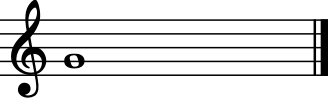

In [6]:
#random number between 0 and the length of the table
rand_ex = random.randint(0,len(data)-1)

file, label = data.iloc[rand_ex, 1], data.iloc[rand_ex, 2]
print ("The file is called {} and the answer is {}" .format(file, label))
display(Image(filename='./q_folders/transpose/bb/' + file))

Now that we have a database of answers we can ask a user a question at random and see if they get it correct.


In [7]:
# def identificationOpen(data): 
#     qs = pd.read_csv(data)
    
#     score = 0
#     total = 0
#     combo = 0 
    
#     while True:
        
#         clear_output(wait=True)
        
#         print ('Answer with letters A - G, type stop to end the game')
#         print (score, '/', total)
#         print ('combo:', combo)
                
#         #get q at random
#         ex = random.randint(0,len(qs)-1)
#         file, label = qs['pngfile'][ex], qs['label'][ex]  
        
#         print ('What note is this? \n')

#         display(Image(filename='./q_folders/stave/' + file))

#         answer = input('')
    
#         #noramlise text
#         answer = answer.upper()
#         answer = answer.strip()

#         if answer == label:
#             print ("Well done!")
#             score += 1
#             total += 1
#             combo += 1

#             continue

#         if answer == 'STOP':
#             if total == 0:
#                 return ('done')
#             else:
#                 print ('You score', round(((score/total)*100), 2), '%')
#                 return score
#         else:
#             print("incorrect, try again")
#             total += 1
#             combo = 0

In [8]:
#get bank of questions
data = './q_folders/stave/labels_treble.csv'

#ask q's
# identificationOpen(data)

 There are a few limitations with this simple game which prevent it from being an ITS:
 
 1. It will sometimes pick the same question twice in a row (there is no need to do this if the student answered correctly).
 2.  It picks at random and therefore jumps between questions which could be confusing for a beginner.
 3. It doesn't know which exercises the student is struggling with in particular and has no strategy for helping them to learn. 


### Part 2: Lower level strategies for an ITS

According to John Self, an ITS is

*‘… [a] computer-based learning system which has some degree of autonomous decision-making with respect to some aspect of its interaction with its users’* (1995) 

 We will now try to get the system to make *intelligent* and autonomous decisions about which questions to present that aim to overcome the aforementioned limitations that should be more effective for the user. 
 
  The system will implement the following low level strategies:
  
 1. Ask the same question again if the student gives a wrong answer so that the user can learn where they went wrong
 2. Pick questions based on probabilities - for example, if a student has answered a question correctly it is half as likely they will be asked that same exercise again. Conversely, if they answer a question incorrectly it is twice as likely they will be asked that question again.
 3. If the success rate is below 80% only move one question up/down at a time to prevent large jumps confusing the student. 

These autonomous decisions and the idea of 'low level strategies' have been inspired directly from the paper 'A System for Concerned Teaching of Musical Aural Skills' by Wiggins (2000, p4). 

_______

## scoreCard function

Below is a function which will keep a score of the questions answered correctly/incorrectly. It will also give question probabilities for the method to use. It does not actually return anything unless the session has ended in which case it returns the table of answers and probabilities that it has been building up. This data can be saved to help build a profile of the user that can be accessed later if desired.

In [9]:
def scoreCard(qs, init=False, finished=None, question=None, correct=None, update_probs=True):
    
    if init == True:

        #make new columns, initialise with 1 to avoid division by zero error
        qs['#_attempts'] = 1
        qs['#_correct'] = 1

        #add probabilities to dataframe
        qs['probability'] = qs['#_attempts'] / qs['#_correct']
        qs['probability'] = qs['probability'] / qs['probability'].sum()
        
    if correct == True:

        #correct
        qs.loc[qs['label'] == question, '#_attempts'] += 1
        qs.loc[qs['label'] == question, '#_correct'] += 1
        
    if update_probs and correct == True:

        #subtract probability mass from question
        qs.loc[qs['label'] == question, 'probability'] = (qs.loc[qs['label'] == question, 'probability'] / 2)
        
    if correct == False:

        #incorrect
        qs.loc[qs['label'] == question, '#_attempts'] += 1
        
    if update_probs and correct == False:

        #add probability mass to question  
        qs.loc[qs['label'] == question, 'probability'] = (qs.loc[qs['label'] == question, 'probability'] * 2)
        
    #normalise probabilities
    qs['probability'] = qs['probability'] / qs['probability'].sum()
    probabilities = qs['probability'].to_numpy() #variable to be accessed by method

    if finished == True:
        
        #minus the 1 that we added earlier to avoid division by zero 
        qs['#_attempts'] -= 1
        qs['#_correct'] -= 1
    
        return qs

 With the above function the system has the data to make intelligent decisions based on probabilities. However, we've not yet got a function to select a question based on the probabilities. 

## generateQ function 

generate Q can be used to 

1. slice a database of q's (for instance just the treble clef notes as opposed to bass and treble clef) 
2. exclude certain questions
3. specify an interval between q's (to avoid jumps that cause difficulty in the case of ordinal questions) 
4. generate a q based on a previous q (for example sticking to a certain subset)
5. draw a question based on the probabilities from the score card


<font color='red'> Room for improvement: generateQ should also take the total, correct, combo data etc because these do decide questions and make a large chunk of the code. 

In [10]:
def generateQ(q_index, probabilities, previous_q=None, init=False, interval=None):

## do not need the first init arg as probs will be random anyway... could be useful later for
## perhaps giving students an initial hint 

#     if init is True:
#         #pick random exercise
#         return np.random.choice(q_index, p=probabilities)

    
    if interval is True:
        #make this more flexible so you can specify the range 
        return np.random.choice(np.arange(-1, 2), p=[1/2, 0, 1/2])
    
    else:
        return np.random.choice(q_index, p=probabilities)
    
#     return ex

## answerCleanup function

answerCleanup will remove leading whitespace and convert all letters to capitals to reduce the chance of a user entering an invalid answer. It can also take regex. It will output 'invalid' if the answer is not valid. It can be modified for different exercises/curricula

In [11]:
def answerCleanup(answer, regex=None):

    answer = answer.strip()
    answer = answer.upper()
    
    if regex: 

        p = re.compile(regex)
        m = p.match(answer)

        if m:
            return answer
        else:
            return 'invalid'
    
    else:
        return answer

In [12]:
regex = r"[a-gA-G 0-9\#\b]"
answer = 'h'
answerCleanup(answer, regex)


'invalid'

## Higher level teaching methods

 In line with the ideas presented by Wiggins in his 2000 paper, we will now implement a function to teach our first higher level teaching method: identificationOpen
 
 ## identificationOpen function
 
  The function will take the questions data as input. It will keep scores using the scoreCard function. It will present questions, take answers and provide feedback. If the score falls below a certain threshold (this could be a parameter) it returns the score which will then be used by the tutor module to choose another higher level teaching method. 

<span style="color:red"> Potential parameters for the identificationOpen:? </span>
- databank of q's
- databank of prompts?
- regex for answer cleanup

But... for now maybe just make a new function, copy and paste. Consolidate later. 
    
Update 23/09/21: new variable 'finished'. When True, the method returns the score. Should this only be used by the tutor module? Should it return anything else? How will it save the scores etc

In [13]:
def identificationOpen(data): 
    
    #convert csv of qs to dataframe
    qs = pd.read_csv(data + 'labels.csv')
    
#     return qs 

#     if slice:
#         qs = qs.iloc[4:6]
    
    #initialise score card based on csv of questions, get init probabilities (random)
    scoreCard(qs, init=True)
    probabilities = qs['probability']
    
    #the index will be used by generateQ to choose questions 
    q_index = qs.index.values
    
    #initialise local variables to track scores and give instant feedback
    score = 0
    total = 0
    combo = 0 

    #feedback is used to help guide the student
    feedback = "Okay, here we go"
    
    finished = False
    
    previous_correct = True
    
    #first loop: pick a question
    while True:
        
        clear_output(wait=True)

        #check for init
        # maybe change this so it teaches??
        if total == 0: #or previous_correct = False?
            ex = generateQ(q_index, probabilities, init=True)
        
        #ask again if they got last q wrong
        elif combo == 0:
            ex = ex 
            
        elif score/total < 0.5:
            finished = True
        
        elif score/total < 0.8:
            #restrict interval for ordinal q's
            ex = ex + generateQ(q_index, probabilities, init=False, interval=True)
            
        else: 
            #draw from probabilities
            ex = generateQ(q_index, probabilities, init=False, interval=False)
        
        #still presents a key error... fix this
        try:    
            file, label = qs['pngfile'][ex], qs['label'][ex]  
        except KeyError:
            print ('There was a key error')
            print (ex)
            break
        
#             continue
        #second loop: present the question, get answer, update scores and probabilities
        while True:
            
            if finished == True: 
                return score/total
    
            print (feedback, '\n \n Answer with letters A - G.\n Type stop to end the game \n') #this could be a prompt?
            # and the prompt could be different things depending on how the game is going and the curricula

            print (score, '/', total)
            print ('combo:', combo)
                
            #ask question, receive answer
            print ('What note is this? \n')
            display(Image(filename = data + file))
            answer = qs['label'][random.randint(0,len(qs)-1)]#[ex]
            
            answer = input('') #hash out to compute answer automatically 
            answer = answerCleanup(answer, regex=None) #hash out to compute answer automatically
            
            if answer == 'STOP': 
                if total == 0:
                    return ('No questions answered')
                else:
                    print ('You score', round(((score/total)*100), 2), '%')
    #                 return score
                    return scoreCard(qs, finished=True)
    
            answer = answerCleanup(answer, regex=r"[a-gA-G 0-9\#\b]") #unhash to test answer

            if answer == label:
                feedback = "Well done!"
                score += 1
                total += 1
                combo += 1
                previous_correct = True

                if previous_correct == True:
                    scoreCard(qs, question=label, correct=True, update_probs=True)
                    break
                
                #do not update probabilities if last question was incorrect
                if previous_correct == False:
                    scoreCard(qs, question=label, correct=True, update_probs=False)
                    break
    
            if answer == 'invalid':
                clear_output(wait=True)
                feedback = 'WARNING: Invalid character in answer. Only letters A-G allowed. Try again.'
                continue

            else:
                feedback = "Incorrect, try again."
                #prompt???
                total += 1
                combo = 0
                previous_correct = False
                scoreCard(qs, question=label, correct=False, update_probs=True)
                
                break

<font color ='red'> known bug: index error<br>
also: fix when it returns the score?

In [14]:
data = './q_folders/stave/' #treble

# data = './q_folders/altoclef/' #alto

# data = './q_folders/transpose/bb/'

In [15]:
# identificationOpen(data)

 ## identificationClosed function
 
 This function is similar to identificationOpen with the exception that it prompts the user with one correct and one incorrect answer which could help the student find the right answer. 

In [16]:
def identificationClosed(data): 
    
    #convert csv of qs to dataframe
    qs = pd.read_csv(data + 'labels.csv')
    
    #initialise score card based on csv of questions, get init probabilities (random)
    scoreCard(qs, init=True)
    probabilities = qs['probability']
    
    #the index will be used by generateQ to choose questions 
    q_index = qs.index.values
    
    #initialise local variables to track scores and give instant feedback
    score = 0
    total = 0
    combo = 0 

    #feedback is used to help guide the student
    feedback = "Okay, here we go"
    
    previous_correct = True
    
    #first loop: pick a question
    while True:
        
        clear_output(wait=True)

        #check for init
        # maybe change this so it teaches??
        if total == 0: #or previous_correct = False?
            ex = generateQ(q_index, probabilities, init=True)
        
        #ask again if they got last q wrong
        elif combo == 0:
            ex = ex 
            
        elif score/total < 0.8:
            #restrict interval for ordinal q's
            ex = ex + generateQ(q_index, probabilities, init=False, interval=True)
        else: 
            #draw from probabilities
            ex = generateQ(q_index, probabilities, init=False, interval=False)
        
        #still presents a key error... fix this
        try:    
            file, label = qs['pngfile'][ex], qs['label'][ex]  
            incorrect_label = qs['label'][random.randint(0,len(qs)-1)]
        except KeyError:
            print ('There was a key error')
            print (ex)
            break
        
#             continue
        
        
        #second loop: present the question, get answer, update scores and probabilities
        while True:
            
            print (feedback, '\n \n Answer with letters A - G.\n Type stop to end the game \n') #this could be a prompt?
            # and the prompt could be different things depending on how the game is going and the curricula

            print (score, '/', total)
            print ('combo:', combo)
                
            #ask question, receive answer
            print ('Is this note {} or {}'.format(label, incorrect_label)) 
            display(Image(filename = data + file))
            answer = qs['label'][random.randint(0,len(qs)-1)]#[ex]
            
            answer = input('') #hash out to compute answer automatically 
            answer = answerCleanup(answer, regex=None) #hash out to compute answer automatically
            
            if answer == 'STOP': 
                if total == 0:
                    return ('No questions answered')
                else:
                    print ('You score', round(((score/total)*100), 2), '%')
    #                 return score
                    return scoreCard(qs, finished=True)
    
            answer = answerCleanup(answer, regex=r"[a-gA-G 0-9\#\b]") #unhash to test answer

            if answer == label:
                feedback = "Well done!"
                score += 1
                total += 1
                combo += 1
                previous_correct = True

                if previous_correct == True:
                    scoreCard(qs, question=file, correct=True, update_probs=True)
                    break
                
                #do not update probabilities if last question was incorrect
                if previous_correct == False:
                    scoreCard(qs, question=file, correct=True, update_probs=False)
                    break
    
            if answer == 'invalid':
                clear_output(wait=True)
                feedback = 'WARNING: Invalid character in answer. Only letters A-G allowed. Try again.'
                continue

            else:
                feedback = "Incorrect, try again."
                #prompt???
                total += 1
                combo = 0
                previous_correct = False
                scoreCard(qs, question=file, correct=False, update_probs=True)
                
                break

<font color='red'> Room for improvement on identification closed: 
- make sure it cant suggest the same label 
- make sure it mixes up incorrect and incorrect (so its not always the first choice)
- can it make decisions intelligently (for example always picking line notes)
- can it reject an answer that is not suggested by the function?

## intervalTraining

In [17]:
# def identificationOpen(data): 
    
#     #convert csv to dataframe
#     qs = pd.read_csv(data)
    
#     #initialise score card 
#     scoreCard(qs, init=True)
    
#     score = 0
#     total = 0
#     combo = 0 

#     while True:
        
#         clear_output(wait=True)

#         print ('Answer with letters A - G, type stop to end the game')
#         print (score, '/', total)
#         print ('combo:', combo)
                
#         #check for init
#         if total == 0:
#             ex = random.randint(0,len(qs)-1)
        
#         #ask again if they got last q wrong
#         elif combo == 0:
#             ex = ex 
           
            
#         elif score/total < 0.8:
#             #interval up/down 1
#             ex = ex + np.random.choice(np.arange(-1, 2), p=[1/2, 0, 1/2])
#         else: 
#             #draw from probabilities
#             ex = np.random.choice(qs.index.to_numpy(), p=qs['probability'])
        
#         try:    
#             file, label = qs['pngfile'][ex], qs['label'][ex]  
#         except KeyError:
#             print ('There was a key error')
#             continue

#         print ('What note is this? \n')

#         display(Image(filename='./q_folders/stave/' + file))

#         answer = input('')

# #         answer = qs['label'][ex]
    
#         #noramlise text
#         answer = answer.upper()
#         answer = answer.strip()

#         if answer == label:
#             print ("Well done!")
#             score += 1
#             total += 1
#             combo += 1

#             scoreCard(qs, question=file, correct=True)
#             continue

#         if answer == 'STOP':
#             if total == 0:
#                 return ('done')
#             else:
#                 print ('You score', round(((score/total)*100), 2), '%')
# #                 return score
#                 return scoreCard(qs, finished=True)

#         else:
#             print("incorrect, try again")
#             total += 1
#             combo = 0
            
#             scoreCard(qs, question=file, correct=False)

# #             return qs

In [18]:
def intervalTraining(blind=False, down=False, difficulty=None):
    
    #convert csv of qs to dataframe
    data = pd.read_csv('./q_folders/interval/labels.csv')
    
    #slice data to q's according to difficulty
    if difficulty == 'easy':
        qs = data.loc[data['difficulty'] == 1].reset_index(drop=True)
    else:
        qs = data
        
    #initialise score card based on csv of questions, get init probabilities (random)
    scoreCard(qs, init=True)
    probabilities = qs['probability']
    
    #the index will be used by generateQ to choose questions 
    q_index = qs.index.values
    
    #initialise local variables to track scores
    score = 0
    total = 0
    combo = 0 
    
    #feedback is used to help guide the student
    feedback = 'Okay, here we go'
    
    finished = False
    
    previous_correct = True
    
    while True:
        
        clear_output(wait=True)
        
        #check for init
        if total == 0:
            ex = generateQ(q_index, probabilities, init=True)
        
        #ask again if last q wrong
        elif combo == 0:
            ex = ex
        
        elif score/total < 0.5:
            finished = True
            
        else:
            #draw from probabilities
            ex = generateQ(q_index, probabilities, init=False, interval=False)
            
        label = qs['label'][ex]
        
        while True:
            
            if finished == True:
                return score/total
            
            print(feedback, '\n \n Which interval did you hear? Type any of the following (case sensitive): \n',
                  *qs.label.to_list())
            
            print (score, '/', total)
            print ('combo:', combo)

    #         display(Image(filename='./q_folders/stave/' + file))
    
            #play / display interval
            pitches = ['F2','G2','A2', 'B2',
            'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3',
            'C4', 'D4', 'E5', 'F5', 'G5']
            
            if previous_correct == False:
                pass
            else:
                p1 = m21.pitch.Pitch(random.choice(pitches)) #pitch1 
                n1 = m21.note.Note(p1) #create note1 from pitch1
                n1.duration.quarterLength = 2
                if down == True:
                    p2 = random.choice([p1.transpose('-' + label), p1.transpose(label)])
        #         p2 = p1.transpose('-' + q) #transpose down
                else:
                    p2 = p1.transpose(label) #transpose up

                #p2.nameWithOctave #if you want to check
                n2 = m21.note.Note(p2) #create note2 from transposed pitch1
                n2.duration.quarterLength = 2

                s = m21.stream.Stream() #create stream
                s.append(n1) #add notes to stream
                s.append(n2)
                if blind == False:
                    s.show() #show music
                else:
                    pass

                sp = m21.midi.realtime.StreamPlayer(s) #play
            sp.play()

            answer = input('')
            
            #noramlise text
            answer = answer.strip()
            
            if answer == 'STOP' or answer == 'stop': 
                if total == 0:
                    return ('No questions answered')
                else:
                    print ('You score', round(((score/total)*100), 2), '%')
    #                 return score
                    return scoreCard(qs, finished=True)

            if answer == label:
                print ("Well done!")
                score += 1
                total += 1
                combo += 1
                previous_correct = True
                time.sleep(1)
                
                if previous_correct == True:
                    scoreCard(qs, question=label, correct=True, update_probs=True)
                    break
                
                #do not update probabilities if last question was incorrect
                if previous_correct == False:
                    scoreCard(qs, question=label, correct=True, update_probs=False)
                    break
                    
            if answer == 'invalid':
                clear_output(wait=True)
                feedback = 'WARNING: Invalid character in answer. Only letters A-G allowed. Try again.'
                continue

            else:
                feedback = "Incorrect, try again."
                #prompt???
                total += 1
                combo = 0
                previous_correct = False
                scoreCard(qs, question=label, correct=False, update_probs=True)
                time.sleep(2)
    
                break


## tutorModule()

The tutorModule will guide the user through the different teaching strategies and act as a rules based chatbot. It will implement some standard NLP approaches such as the preprocessing of text. 

In [19]:
# data = './q_folders/stave/' #treble

# data = './q_folders/altoclef/' #alto

# data = './q_folders/transpose/bb/'

In [20]:
porter = PorterStemmer()
Lem = WordNetLemmatizer()

def preProcess(word):
    word = Lem.lemmatize(word)
    word = porter.stem(word)
    return word

def preProcessList(lst):
    words = []
    for word in lst:
        word = preProcess(word)
        words.append(word)
        
    return words

In [21]:
#key words for different subjects (bag of words)
notation = ['notes', 'clef', 'reading', 'notation']
interval = ['interval', 'distance', 'major', 'minor']
transpose = ['transpose', 'trumpet', 'instruments']

#preProcess lists
notation = preProcessList(notation)
interval = preProcessList(interval)
transpose = preProcessList(transpose)

In [22]:
def subjectSelect(greeting):

    tokens = greeting.split()
    for token in tokens:
        token = preProcess(token)
        if token in notation:
            print ('Okay, would you like to train on the alto or treble/bass clef?')
            answer = input()
            if answer == 'treble/bass':
                ('Okay, let\s do notes on the treble clef')
                identificationOpen('./q_folders/stave/')
            if answer == 'alto':
                ('Okay, let\s do notes on the alto clef.')
                identificationOpen('./q_folders/altoclef/')

        if token in interval:
            print ('Okay, let\s do interval training')
            intervalTraining(blind=True, difficulty='medium', down=False)
                 
        if token in transpose:
            print ('Okay, let\s do interval training')
            identificationOpen('./q_folders/transpose/bb/')
        
    print ('I do not understand - which of these subjects would you like to try?')
    print ('Stave notation \nInterval training \nTransposition')


Well done! 
 
 Answer with letters A - G.
 Type stop to end the game 

10 / 11
combo: 6
What note is this? 



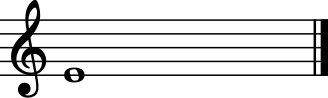

 stop


You score 90.91 %
I do not understand - which of these subjects would you like to try?
Stave notation 
Interval training 
Transposition
None
What do you want to learn today?


 stop


In [29]:
while True:
    print ('What do you want to learn today?')
    answer = input()
    if answer == 'stop':
        break
    print (subjectSelect(answer))

Okay, here we go 
 
 Which interval did you hear? Type any of the following (case sensitive): 
 M3 P5 P8
1 / 1
combo: 1


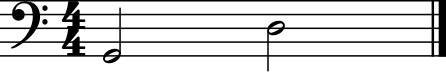

 stop


You score 100.0 %


,label,difficulty,#_attempts,#_correct,probability
0,M3,1,0,0,0.4
1,P5,1,0,0,0.4
2,P8,1,1,1,0.2


In [28]:
# intervalTraining(blind=False, difficulty='easy', down=True)

_________

In [30]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [27]:
def tutorModule(student=None):
    
    if student == None:
        
        print ('Hello, you must be new here. What is your name?')
        name = input()
        print ('Hello {} - what would you like to learn today?'.format(name))
        print (modules)
        subject = input()
        
        if subject == 'Notes on treble clef':
            data = './q_folders/stave/'
        else:
            data = './q_folders/altoclef/'
            
        score = identificationOpen(data)
        
        if score < 0.5:
            
            identificationClosed(data)

In [34]:
tutorModule()

Hello, you must be new here. What is your name?


 stop


Hello stop - what would you like to learn today?


NameError: name 'modules' is not defined

## notes on tutor module

- work a stop mechanism into all methods that returns the final score (can even be a paramater, max number of q's to ask? so that it does not go on infinitely?)
- get the bot to take the final percentage in (say below 50%) and choose a new method based on that?
- could do it via variable 'finish', so if finish == True: return scoreCard and score/total? and that will decide next thing to do.
- things such as max no of questions or a score boundary could decide if finished is true or not  

In [35]:
# identificationClosed(data)

In [36]:
def identificationOpen(data): 
    
    #convert csv to dataframe
    qs = pd.read_csv(data)
    
    #initialise score card 
    scoreCard(qs, init=True)
    
    score = 0
    total = 0
    combo = 0 

    while True:
        
        clear_output(wait=True)

        print ('Answer with letters A - G, type stop to end the game')
        print (score, '/', total)
        print ('combo:', combo)
                
        #check for init
        if total == 0:
            ex = random.randint(0,len(qs)-1)
        
        #ask again if they got last q wrong
        elif combo == 0:
            ex = ex 
           
            
        elif score/total < 0.8:
            #interval up/down 1
            ex = ex + np.random.choice(np.arange(-1, 2), p=[1/2, 0, 1/2])
        else: 
            #draw from probabilities
            ex = np.random.choice(qs.index.to_numpy(), p=qs['probability'])
        
        try:    
            file, label = qs['pngfile'][ex], qs['label'][ex]  
        except KeyError:
            print ('There was a key error')
            continue

        print ('What note is this? \n')

        display(Image(filename='./q_folders/stave/' + file))

        answer = input('')

#         answer = qs['label'][ex]
    
        #noramlise text
        answer = answer.upper()
        answer = answer.strip()

        if answer == label:
            print ("Well done!")
            score += 1
            total += 1
            combo += 1

            scoreCard(qs, question=file, correct=True)
            continue

        if answer == 'STOP':
            if total == 0:
                return ('done')
            else:
                print ('You score', round(((score/total)*100), 2), '%')
#                 return score
                return scoreCard(qs, finished=True)

        else:
            print("incorrect, try again")
            total += 1
            combo = 0
            
            scoreCard(qs, question=file, correct=False)

#             return qs

In [38]:
# intervalTraining(blind=True, difficulty='medium', down=False)

<font color = 'red'> IMPORTANT teaching aspect: can it teach them what they are often mistaking some intervals for? This could be applicable to anything and perhaps work via the scoreCard function

In [39]:
qs = pd.read_csv('./q_folders/interval/labels.csv')
qs#['interval']#.to_list()
new = qs.loc[qs['difficulty'] == 1].reset_index(drop=True)
new.index += 1
new

,label,difficulty
1,M3,1
2,P5,1
3,P8,1


In [40]:
print('Which interval did you hear? Type any of the following: \n', *new.interval.to_list())

AttributeError: 'DataFrame' object has no attribute 'interval'

In [41]:
for i in range(len(new)):
    print (new.index[i], new.interval[i])

AttributeError: 'DataFrame' object has no attribute 'interval'

In [42]:
new.interval

AttributeError: 'DataFrame' object has no attribute 'interval'

## TODO:

1. Should 'prompt' or 'feedback' be a constantly chagnging variable dependent on prev answer/the answer to the current q? Maybe they should both be variables. 

generateQ(data=(index or dataframe), init=None, range=None, probabilities=1d array)


Interface: Make sure it gives some instant feedback 

Can it be smart choosing which intervals to go between?

If a student is consistently struggling ask questions the system knows they got right to build confidence/change method or strategy. Conversely, if a student is doing really well start to challenge them more. 

Next step: start **teaching** as opposed to testing. Flash cards, mnemonic, prompts etc. 



In [43]:
def identificationOpen(data): 
    qs = pd.read_csv(data)
    
    qs['#_attempts'] = 1
    qs['#_correct'] = 1
    qs ['probability'] = qs['#_attempts'] / qs['#_correct']
    qs['probability'] = qs['probability'] / qs['probability'].sum()
    
    score = 0
    total = 0
    combo = 0 

    while True:
        
        clear_output(wait=True)

        print ('Answer with letters A - G, type stop to end the game')
        print (score, '/', total)
        print ('combo:', combo)
                
        #check for init
        if total == 0:
            ex = random.randint(0,len(qs)-1)
        
        #ask again if they got last q wrong
        elif combo == 0:
            ex = ex 
            
        #interval of no more than 1
        elif score/total < 0.8:
            ex = ex + np.random.choice(np.arange(-1, 2), p=[1/2, 0, 1/2])
        else: 
            ex = np.random.choice(qs.index.to_numpy(), p=probabilities)
        
        try:    
            file, label = qs['pngfile'][ex], qs['label'][ex]  
        except KeyError:
            print ('There was a key error')
            continue

        print ('What note is this? \n')

        display(Image(filename='./q_folders/stave/' + file))

        answer = input('')

#         answer = qs['label'][ex]
    
        #noramlise text
        answer = answer.upper()
        answer = answer.strip()

        if answer == label:
            print ("Well done!")
            score += 1
            total += 1
            combo += 1

            #correct
            qs.loc[qs['pngfile'] == file, '#_attempts'] += 1
            qs.loc[qs['pngfile'] == file, '#_correct'] += 1

            #updates probabilities 
#             qs['probability'] = qs['#_attempts'] / qs['#_correct']
            qs.loc[qs['pngfile'] == file, 'probability'] = (qs.loc[qs['pngfile'] == file, 'probability'] / 2)
            qs['probability'] = qs['probability'] / qs['probability'].sum()
            probabilities = qs['probability'].to_numpy()

            continue

        if answer == 'STOP':
            if total == 0:
                return ('done')
            else:
                print ('You score', round(((score/total)*100), 2), '%')
#                 return score
                return qs
        else:
            print("incorrect, try again")
            total += 1
            combo = 0
            
            #incorrect
            qs.loc[qs['pngfile'] == file, '#_attempts'] += 1
            # qs.loc[qs['pngfile'] == file, '#_correct'] += 1

            #updates probabilities 
            # qs ['probability'] = qs['#_attempts'] / qs['#_correct']
            qs.loc[qs['pngfile'] == file, 'probability'] = (qs.loc[qs['pngfile'] == file, 'probability'] * 2)
            qs['probability'] = qs['probability'] / qs['probability'].sum()
            probabilities = qs['probability'].to_numpy()

            
#             return qs


Below is also a detailed log of which questions were answered correctly and incorrectly which is constructed from the question table.  This data could be saved and used the next time the method is used for teaching and to contribute to the overall profile of the student. 

__________

In [ ]:
def identificationClosed(data): 
    qs = pd.read_csv(data)

    score = 0
    total = 0
    combo = 0 

    while True:

        clear_output(wait=True)

        print (score, '/', total)
                
        #check for init
        if total == 0:
            ex = random.randint(0,len(qs)-1)
        
        #ask again if they got last q wrong
        elif combo == 0:
            ex = ex 
            
        #interval of no more than 1
        elif score/total < 0.8:
            ex = ex + np.random.choice(np.arange(-1, 2), p=[1/2, 0, 1/2])
        else: 
            ex = ex + np.random.choice(np.arange(-3, 4), p=[1/4, 1/4, 0, 0, 0, 1/4, 1/4])
        
        try:    
            file, label = qs['pngfile'][ex], qs['label'][ex]  
        except KeyError:
            print ('There was a key error')
            continue
        
        try:
            print ('Is this note ' + label + ' or ' + qs['label'][ex + np.random.choice([1,3,5])])
            
        except KeyError:
            print ('Is this note ' + label + ' or ' + qs['label'][ex - np.random.choice([1,3,5])])

        display(Image(filename='./q_folders/stave/' + file))

        answer = input('')

#         answer = qs['label'][ex]
    
        #noramlise text
        answer = answer.upper()
        answer = answer.strip()

        if answer == label:
            print ("Well done!")
            score += 1
            total += 1
            combo += 1
            continue

        if answer == 'STOP':
            if total == 0:
                return ('done')
            else:
                print ('You score', round(((score/total)*100), 2), '%')
                return score
        else:
            print("incorrect, try again")
            total += 1
            combo = 0
            


In [ ]:
data = './q_folders/stave/labels.csv'
# method = identificationOpen
identificationClosed(data)

In [ ]:
qs = pd.read_csv(data)
qs
# len(qs)

In [ ]:
import re
 
# Function to check if a string
# contains only special characters
def onlySpecialCharacters(Str):
 
    # Regex to check if a string contains
    # only special characters
    regex = r"a-gA-g 0-9\#\b"
 
    # Compile the ReGex
    p=re.compile(regex)
 
    # If the string is empty
    # then print No
    if(len(Str) == 0):
        print("No")
        return
 
    # Print Yes If the string matches
    # with the Regex
    if(re.search(p, Str)):
        print("Yes")
    else:
        print("No")
 

 
# Given string str
Str = 
 
# Function Call
onlySpecialCharacters(Str)
 

In [ ]:
def answerCleanup(answer, regex, warning):
    answer = answer.strip()
    answer = answer.upper()

    regex = r"[a-gA-G 0-9\#\b]"
    p = re.compile(regex)
    m = p.match(answer)
    
    if m:
        return answer
    else:
        return warning

In [ ]:
warning = 'Invalid character in answer. Only letters A-G allowed. Use # for sharp, lowercase b for flat.'
answerCleanup('H', regex="[a-gA-G 0-9\#\b]", warning=warning)

In [ ]:
s = 'hello world'
s.strip()

Can you edit it so that it can keep a detailed track of progress (like a dataframe) and save?